In [ ]:
!pip install torch==2.5.0 torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 MB 3.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu12

In [ ]:
import torchvision
print(torchvision.__version__)

0.20.0+cpu


In [ ]:
import torchvision

# This will download (if not already present) the complete Oxford-IIIT Pet dataset
# into the specified root directory. By default, it only loads the 'trainval' split.
# So we do it once for 'trainval' and once for 'test'.

root_dir = "./oxford_pet_data"  # or any folder you choose

trainval_data = torchvision.datasets.OxfordIIITPet(
    root=root_dir,
    split="trainval",
    target_types=["category"],  # or ["segmentation"] / ["category", "segmentation"]
    download=True,
)

100%|██████████| 792M/792M [00:31<00:00, 25.1MB/s]


Extracting oxford_pet_data/oxford-iiit-pet/images.tar.gz to oxford_pet_data/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 9.28MB/s]


Extracting oxford_pet_data/oxford-iiit-pet/annotations.tar.gz to oxford_pet_data/oxford-iiit-pet


In [ ]:
import os
import xml.etree.ElementTree as ET

def parse_xml_for_bbox(xml_file):
    """Parse the Oxford-IIIT Pet XML file for bounding box [xmin, ymin, xmax, ymax]."""
    if not os.path.exists(xml_file):
        # Return None or raise an exception.
        # For skipping, you could do:
        return None, None  # Indicate missing
    tree = ET.parse(xml_file)
    root = tree.getroot()

    bboxes = []
    labels = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(name)

    return bboxes, labels

In [ ]:
def read_split_file(file_path):
    """
    Reads lines from trainval.txt or test.txt.
    Returns a list of image IDs (strings).
    """
    with open(file_path, 'r') as f:
        lines = f.read().strip().split('\n')
    # Each line might look like "Abyssinian_1 1 1"
    # We'll take the first token as the image base name
    return [line.split()[0] for line in lines if line.strip()]

In [ ]:
def build_annotations_list(root_dir, txt_filename):
    """
    Build a list of annotation dicts from trainval.txt or test.txt.
    Each dict might look like:
        {
          'image_id': 'Abyssinian_1.jpg',
          'boxes': [[xmin, ymin, xmax, ymax]],    # can have multiple
          'labels': ['Abyssinian']                # or numeric label if you prefer
        }
    """
    images_dir = os.path.join(root_dir, "images")
    xmls_dir   = os.path.join(root_dir, "annotations", "xmls")
    txt_path   = os.path.join(root_dir, "annotations", txt_filename)

    image_bases = read_split_file(txt_path)

    annotation_dicts = []
    for base in image_bases:
        xml_file  = os.path.join(xmls_dir, f"{base}.xml")
        image_file = os.path.join(images_dir, f"{base}.jpg")

        bboxes, labels = parse_xml_for_bbox(xml_file)
        if bboxes is None or labels is None:
            # Means parse_xml_for_bbox returned None -> skip
            print(f"Skipping missing file: {xml_file}")
            continue

        # Also check if image_file actually exists
        if not os.path.exists(image_file):
            print(f"Skipping missing image: {image_file}")
            continue

        annotation_dicts.append({
            'image_file': image_file,
            'boxes': bboxes,       # list of [xmin, ymin, xmax, ymax]
            'labels': labels       # list of names
        })
    return annotation_dicts

def load_oxford_pet_annotations(root_dir):
    """
    Loads 'trainval.txt' and 'test.txt' from the dataset folder, returning
    two lists of annotation dicts.
    """
    trainval_anns = build_annotations_list(root_dir, "trainval.txt")
    # test_anns     = build_annotations_list(root_dir, "test.txt")
    # return trainval_anns, test_anns
    return trainval_anns

In [ ]:
import numpy as np
from PIL import Image
import torch

class OxfordPetBboxDatasetAlbumentations(torch.utils.data.Dataset):
    def __init__(self, annotations, transform=None):
        """
        Args:
            annotations: list of dicts, each like:
                {
                  'image_file': '/path/to/img.jpg',
                  'boxes': [[xmin, ymin, xmax, ymax], ...],
                  'labels': ['cat', ...]
                }
            transform: An Albumentations transform pipeline.
        """
        self.annotations = annotations
        self.transform = transform

        # Build a mapping from species to index.
        species_set = set()
        for ann in annotations:
            species_set.update(ann['labels'])
        self.species_to_idx = {sp: i for i, sp in enumerate(sorted(species_set))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = ann['image_file']
        boxes = ann['boxes']  # List of bounding boxes in pascal_voc format
        labels_str = ann['labels']  # List of label strings

        # Load image as a NumPy array.
        image = np.array(Image.open(img_path).convert('RGB'))

        if self.transform:
            # Albumentations expects keys: image, bboxes, labels.
            # It will output a dict with keys: image, bboxes, labels.
            transformed = self.transform(image=image, bboxes=boxes, labels=labels_str)
            image = transformed['image']
            boxes = transformed['bboxes']
            labels_str = transformed['labels']

        # Convert bounding boxes to a tensor.
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        # Convert label strings to indices.
        labels_tensor = torch.tensor([self.species_to_idx[l] for l in labels_str], dtype=torch.int64)

        return image, {"boxes": boxes_tensor, "labels": labels_tensor}

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

albumentations_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.RandomResizedCrop(
            size=(224,224),
            scale=(0.8, 1.0),        # fraction of area for crop
            ratio=(0.75, 1.33),      # aspect ratio range (default values; adjust if needed)
            p=1.0
        ),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2(),  # Converts the image to a PyTorch tensor
    ],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
)

In [ ]:
# Assume you have loaded your annotations (a list of dictionaries) from your XML and txt files.
trainval_anns = load_oxford_pet_annotations("/content/oxford_pet_data/oxford-iiit-pet")
trainval_dataset = OxfordPetBboxDatasetAlbumentations(trainval_anns, transform=albumentations_transform)


Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Abyssinian_104.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Bengal_111.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/samoyed_10.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Bengal_175.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_14.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_156.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Egyptian_Mau_186.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/Ragdoll_199.xml
Skipping missing file: /content/oxford_pet_data/oxford-iiit-pet/annotations/xmls/saint_bernard_15.xml


In [ ]:
print(len(trainval_anns))
print(len(trainval_dataset))

3671
3671


In [ ]:
#classes = trainval_dataset._labels
#print(classes)

AttributeError: 'OxfordPetBboxDatasetAlbumentations' object has no attribute '_labels'

In [ ]:
print(trainval_anns[56])

{'image_file': '/content/oxford_pet_data/oxford-iiit-pet/images/american_bulldog_107.jpg', 'boxes': [[87.0, 68.0, 272.0, 224.0]], 'labels': ['dog']}


In [ ]:
print(trainval_dataset[56])

(tensor([[[ 0.2796, -0.1486, -0.5596,  ...,  0.9646,  0.8618,  0.8276],
         [ 0.9132,  0.8789,  0.6221,  ...,  0.8618,  0.8789,  0.7591],
         [ 0.6221,  0.8276,  0.6906,  ...,  0.7762,  0.7591,  0.7419],
         ...,
         [-1.6213,  0.8789,  1.2043,  ..., -0.4397, -0.6965, -0.7650],
         [-1.7412,  0.9474, -0.1143,  ..., -0.4911, -0.6109, -0.7479],
         [-1.6042,  1.0502, -0.8335,  ..., -0.6452, -0.7308, -0.8335]],

        [[ 0.5203,  0.4853, -0.0224,  ...,  0.4503,  0.5028,  0.5203],
         [ 1.3606,  1.3957,  1.3606,  ...,  0.5028,  0.4503,  0.4328],
         [ 1.4657,  1.3256,  1.2906,  ...,  0.5028,  0.4503,  0.4503],
         ...,
         [-1.5105,  0.6954,  0.8704,  ..., -0.5126, -0.5126, -0.6352],
         [-1.5980,  0.7304, -0.1625,  ..., -0.6176, -0.7402, -0.5126],
         [-1.5980,  0.9055, -0.8803,  ..., -0.6702, -0.6702, -0.7227]],

        [[ 0.9494,  0.7054,  0.3393,  ...,  0.5834,  0.3045,  0.4091],
         [ 1.4200,  1.1062,  0.9668,  ...,  

In [ ]:
def detection_collate_fn(batch):
    """
    Custom collate function for object detection.

    Args:
        batch: list of tuples (image_tensor, target_dict)

    Returns:
        batch_images: Tensor [B, C, H, W]
        batch_targets: list of target dicts (each with 'boxes' and 'labels')
    """
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)  # This works because all images are resized

    return images, targets

In [ ]:
import torch
from torch.utils.data import DataLoader, ConcatDataset, random_split

# For reproducibility
torch.manual_seed(42)

train_size = int(0.85 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_ds, val_ds = random_split(trainval_dataset, [train_size, val_size])

print(f"Split trainval into: train={len(train_ds)}, val={len(val_ds)}")

# 4) DataLoaders
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=2, collate_fn=detection_collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=2, collate_fn=detection_collate_fn)
#test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=2)
print("Dataloaders created successfully!")

Split trainval into: train=3120, val=551
Dataloaders created successfully!


In [ ]:
# Example: iterate one batch
for images, targets in train_loader:
    print(images.shape)  # e.g., torch.Size([8, 3, 224, 224])
    print(targets)
    break

torch.Size([8, 3, 224, 224])
[{'boxes': tensor([[ 36.8292,  33.8932, 150.5997, 165.7612]]), 'labels': tensor([1])}, {'boxes': tensor([[117.7177,  63.2630, 195.7478,  99.0099]]), 'labels': tensor([1])}, {'boxes': tensor([[ 18.9109,  64.6492, 184.4214, 206.7177]]), 'labels': tensor([0])}, {'boxes': tensor([[ 73.7037,  32.8140, 122.1495, 119.3450]]), 'labels': tensor([1])}, {'boxes': tensor([[ 60.4244,  18.4329, 130.6734,  82.5474]]), 'labels': tensor([0])}, {'boxes': tensor([[  0.0000,   0.0000, 220.4971, 205.4842]]), 'labels': tensor([1])}, {'boxes': tensor([[163.9376,   0.5333, 215.5715,  43.2000]]), 'labels': tensor([0])}, {'boxes': tensor([[ 48.9458, 107.4370, 130.7656, 202.0148]]), 'labels': tensor([1])}]


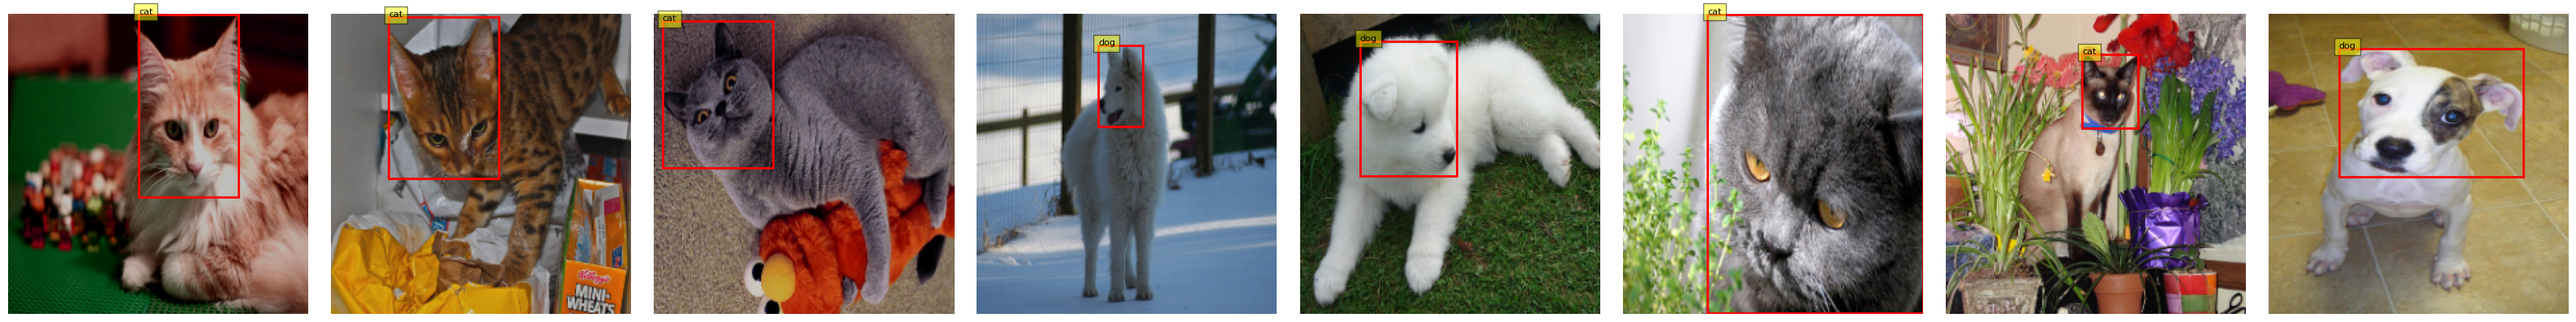

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_batch(images, targets, class_names):
    """
    Visualize a batch of images with bounding boxes.

    Args:
        images (Tensor): Batch of images of shape [B, C, H, W].
        targets (list): List of dicts; each dict contains 'boxes' (Tensor, shape [N,4])
                        and 'labels' (Tensor, shape [N]).
        class_names (dict): Mapping from label index to class name.
    """
    batch_size = images.shape[0]
    # Create a subplot for each image in the batch.
    fig, axes = plt.subplots(1, batch_size, figsize=(4 * batch_size, 4))
    if batch_size == 1:
        axes = [axes]

    # ImageNet normalization parameters.
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    for idx, ax in enumerate(axes):
        # Convert tensor image to numpy array and transpose to HWC.
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        # Unnormalize the image.
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        # Get boxes and labels for the current image.
        boxes = targets[idx]['boxes'].cpu().numpy()  # shape: [N, 4]
        labels = targets[idx]['labels'].cpu().numpy()  # shape: [N]
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            width = x_max - x_min
            height = y_max - y_min
            # Draw rectangle
            rect = patches.Rectangle(
                (x_min, y_min), width, height,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)
            # Annotate label name.
            ax.text(
                x_min, y_min, class_names[label],
                bbox=dict(facecolor='yellow', alpha=0.5),
                fontsize=8, color='black'
            )
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Create a mapping from label indices to class names using your dataset's species_to_idx.
class_names = {v: k for k, v in trainval_dataset.species_to_idx.items()}

# Get one batch from your DataLoader.
images, targets = next(iter(train_loader))
visualize_batch(images, targets, class_names)

In [ ]:
txt_path   = os.path.join("/content/oxford_pet_data/oxford-iiit-pet", "annotations", "trainval.txt")
image_bases = read_split_file(txt_path)
print(image_bases[56])

american_bulldog_106
